### Default Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup

%matplotlib inline

### Modeling imports

## Doing the modeling!

In [4]:
merged = pd.read_csv('./data/merged_v3.csv')
merged.head()

,year,player,listed_pos,age,tm_name,g,gs,mp,per,ts%,...,blk,tov,pf,pts,year-player,award_tm,award_pos,starter,reserve,all_star
0,1989.0,kareem abdul-jabbar,C,41.0,LAL,74.0,74.0,1695.0,12.9,0.511,...,85.0,95.0,196.0,748.0,1989.0kareem abdul-jabbar,0,C,0.0,1.0,1.0
1,1989.0,mark acres,C,26.0,BOS,62.0,0.0,632.0,8.2,0.507,...,6.0,23.0,94.0,137.0,1989.0mark acres,0,C,0.0,0.0,0.0
2,1989.0,michael adams,PG,26.0,DEN,77.0,77.0,2787.0,17.5,0.567,...,11.0,180.0,149.0,1424.0,1989.0michael adams,0,PG,0.0,0.0,0.0
3,1989.0,mark aguirre,SF,29.0,TOT,80.0,76.0,2597.0,16.4,0.524,...,36.0,208.0,229.0,1511.0,1989.0mark aguirre,0,SF,0.0,0.0,0.0
4,1989.0,danny ainge,PG,29.0,TOT,73.0,54.0,2377.0,18.0,0.554,...,8.0,145.0,186.0,1281.0,1989.0danny ainge,0,PG,0.0,0.0,0.0


In [5]:
merged['target'] = merged['award_tm'].map(lambda x: 1 if x > 0 else 0)

In [6]:
awardpos_dict = {'C':'C',
                 'PG': 'G',
                 'SF':'F',
                 'PF':'F',
                 'SG': 'G',
                 'F':'F',
                 'G':'G'}

In [7]:
merged['award_pos'] = merged['award_pos'].apply(lambda x: awardpos_dict.get(x))

In [8]:
merged.dtypes[merged.dtypes != float]

player         object
listed_pos     object
tm_name        object
year-player    object
award_tm        int64
award_pos      object
target          int64
dtype: object

In [9]:
merged['tm_name'].unique()

array(['LAL', 'BOS', 'DEN', 'TOT', 'WSB', 'SAC', 'SAS', 'POR', 'PHI',
       'NJN', 'UTA', 'SEA', 'LAC', 'ATL', 'DAL', 'CHH', 'GSW', 'MIL',
       'NYK', 'CHI', 'PHO', 'HOU', 'MIA', 'CLE', 'DET', 'IND', 'ORL',
       'MIN', 'VAN', 'TOR', 'WAS', 'MEM', 'NOH', 'CHA', 'NOK', 'OKC',
       'BRK', 'NOP', 'CHO'], dtype=object)

**Some data cleaning still!**
- Need to change some team names from expansion, moving, and other random team seasons to match

In [10]:
team_dict = {'NJN': 'BRK', 'NOH':'NOP', 'WSB':'WAS', 'NOK':'NOP', 'SEA':'OKC', 'CHH':'CHA', 'VAN':'MEM', 'CHO':'CHA'}

merged['tm_name'] = merged['tm_name'].map(lambda x: x if team_dict.get(x) == None else team_dict.get(x))


**Notes**
- Need to actually hold out a couple years fully for unseen data. So we'll have:
    - Train data (20)
    - Test data (6)
    - Holdout data (2)
- Look up `Categorical Encoder`

In [11]:
missing = {'shaquille o\'neal': 1, 
           'tim duncan': 1, 
           'kevin garnett': 1,
           'jason kidd': 1,
           'gary payton': 1,
           'alonzo mourning': 2, 
           'grant hill': 2, 
           'karl malone': 2,
           'kobe bryant': 2, 
           'allen iverson': 2, 
           'david robinson': 3, 
           'vince carter': 3,
           'chris webber': 3, 
           'eddie jones': 3, 
           'stephon marbury': 3}

Next, loop and add `target = 1` and `award_tm = missing.get('player')` for players in this list, for `year == 2000`

In [12]:
for player in list(missing.keys()):
    merged.loc[(merged['year'] == 2000) & (merged['player'] == player), 'award_tm'] = missing.get(player)
    merged.loc[(merged['year'] == 2000) & (merged['player'] == player), 'target'] = 1

In [13]:
## double check
merged[(merged['year'] == 2000) & merged['target']==1]

,year,player,listed_pos,age,tm_name,g,gs,mp,per,ts%,...,tov,pf,pts,year-player,award_tm,award_pos,starter,reserve,all_star,target
4502,2000.0,kobe bryant,SG,21.0,LAL,66.0,62.0,2524.0,21.7,0.546,...,182.0,220.0,1485.0,2000.0kobe bryant,2,G,1.0,0.0,1.0,1
4516,2000.0,vince carter,SF,23.0,TOR,82.0,82.0,3126.0,23.4,0.543,...,178.0,263.0,2107.0,2000.0vince carter,3,F,1.0,0.0,1.0,1
4563,2000.0,tim duncan,PF,23.0,SAS,74.0,74.0,2875.0,24.8,0.555,...,242.0,210.0,1716.0,2000.0tim duncan,1,F,1.0,0.0,1.0,1
4586,2000.0,kevin garnett,PF,23.0,MIN,81.0,81.0,3243.0,23.6,0.545,...,268.0,205.0,1857.0,2000.0kevin garnett,1,F,1.0,0.0,1.0,1
4621,2000.0,grant hill,SF,27.0,DET,74.0,74.0,2776.0,24.5,0.565,...,240.0,190.0,1906.0,2000.0grant hill,2,F,1.0,0.0,1.0,1
4633,2000.0,allen iverson,SG,24.0,PHI,70.0,70.0,2853.0,20.0,0.496,...,230.0,162.0,1989.0,2000.0allen iverson,2,G,1.0,0.0,1.0,1
4652,2000.0,eddie jones,SG,28.0,CHA,72.0,72.0,2807.0,19.9,0.555,...,160.0,176.0,1446.0,2000.0eddie jones,3,G,1.0,0.0,1.0,1
4661,2000.0,jason kidd,PG,26.0,PHO,67.0,67.0,2616.0,18.4,0.498,...,226.0,148.0,959.0,2000.0jason kidd,1,G,1.0,0.0,1.0,1
4689,2000.0,karl malone,PF,36.0,UTA,82.0,82.0,2947.0,27.1,0.582,...,231.0,229.0,2095.0,2000.0karl malone,2,F,0.0,1.0,1.0,1
4692,2000.0,stephon marbury,PG,22.0,BRK,74.0,74.0,2881.0,20.7,0.528,...,270.0,195.0,1640.0,2000.0stephon marbury,3,G,0.0,0.0,0.0,1


In [14]:
## save it!
merged.to_csv('./data/merged_v5.csv', index=False)

In [15]:
## gonna drop 1999 because of no all star game...
model_df = merged[merged['year'] != 1999]


train_yrs = [1989, 1990, 1991,
             1994, 1995,
             1997, 1998, 2000,
             2002, 2003, 2004,
             2006, 2007, 2008,
             2010, 2011, 2012,
             2014, 2015, 2016]
             
test_yrs = [1992,
            1996,
            2001,
            2005,
            2013,
            2017]

hold_yrs = [1993, 2009]

drop_cols = ['target', 'year-player', 'player', 'award_tm', 'listed_pos']

X_train = model_df.drop(drop_cols, axis=1).loc[model_df['year'].isin(train_yrs)].reset_index(drop=True)
X_test = model_df.drop(drop_cols, axis=1).loc[model_df['year'].isin(test_yrs)].reset_index(drop=True)

y_train = model_df.loc[model_df['year'].isin(train_yrs), 'target']
y_test = model_df.loc[model_df['year'].isin(test_yrs), 'target']

X_hold = model_df.drop(drop_cols, axis=1).loc[model_df['year'].isin(hold_yrs)].reset_index(drop=True)
y_hold = model_df.loc[model_df['year'].isin(hold_yrs), 'target']

print('Train shapes',X_train.shape, y_train.shape)
print('Test shapes',X_test.shape, y_test.shape)
print('Hold shapes', X_hold.shape, y_hold.shape)

Train shapes (8736, 52) (8736,)
Test shapes (2671, 52) (2671,)
Hold shapes (833, 52) (833,)


### Start here!!
- model TTS starting point

In [16]:
## saving progress
# X_train.to_csv('./data/X_train.csv')
# X_test.to_csv('./data/X_test.csv')
# y_train.to_csv('./data/y_train.csv')
# y_test.to_csv('./data/y_test.csv')
# X_hold.to_csv('./data/X_hold.csv')
# y_hold.to_csv('./data/y_hold.csv')

# X_train = pd.read_csv('./data/X_train.csv', index_col=0)
# X_test = pd.read_csv('./data/X_test.csv', index_col=0)
# y_train = pd.read_csv('./data/y_train.csv', index_col=0)
# y_test = pd.read_csv('./data/y_test.csv', index_col=0)
# X_hold = pd.read_csv('./data/X_hold.csv', index_col=0)
# y_hold = pd.read_csv('./data/y_hold.csv', index_col=0)

## Model time!!
1. Set up pipelines!

#### Time to set up a process for label, then one-hot encoding
- For our two categorical columns

In [17]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le1 = LabelEncoder()
X_train['tm_name_le'] = le1.fit_transform(X_train['tm_name'])
X_test['tm_name_le'] = le1.transform(X_test['tm_name'])
X_hold['tm_name_le'] = le1.transform(X_hold['tm_name'])

In [18]:


onehot = OneHotEncoder(sparse=False)
# X_train['tm_name'] = 
oh_train = onehot.fit_transform(X_train['tm_name_le'].values.reshape(-1,1))
oh_test = onehot.transform(X_test['tm_name_le'].values.reshape(-1, 1))
oh_hold = onehot.transform(X_hold['tm_name_le'].values.reshape(-1, 1))


In [19]:
tm_name_cols = ['tm_encode_' + i for i in np.sort(X_train.tm_name.unique())]
X_train = pd.concat([X_train, pd.DataFrame(oh_train, columns=tm_name_cols)], axis=1)\
                    .drop(['tm_name', 'tm_name_le', 'year'], axis=1)

X_test = pd.concat([X_test, pd.DataFrame(oh_test, columns=tm_name_cols)], axis=1)\
                    .drop(['tm_name', 'tm_name_le', 'year'], axis=1)
    
X_hold = pd.concat([X_hold, pd.DataFrame(oh_hold, columns=tm_name_cols)], axis=1)\
                    .drop(['tm_name', 'tm_name_le', 'year'], axis=1)

In [20]:
X_train.shape

(8736, 81)

In [21]:
X_test.head()

,age,g,gs,mp,per,ts%,3par,ftr,orb%,drb%,...,tm_encode_ORL,tm_encode_PHI,tm_encode_PHO,tm_encode_POR,tm_encode_SAC,tm_encode_SAS,tm_encode_TOR,tm_encode_TOT,tm_encode_UTA,tm_encode_WAS
0,23.0,71.0,1.0,934.0,13.5,0.533,0.000,0.280,9.5,20.9,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22.0,81.0,11.0,1538.0,12.6,0.469,0.111,0.128,1.5,6.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,29.0,68.0,6.0,926.0,10.1,0.576,0.020,0.444,11.4,19.2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29.0,78.0,78.0,2795.0,17.1,0.506,0.313,0.292,2.2,10.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,27.0,76.0,8.0,1175.0,10.9,0.477,0.113,0.176,5.7,9.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
X_hold.head()

,age,g,gs,mp,per,ts%,3par,ftr,orb%,drb%,...,tm_encode_ORL,tm_encode_PHI,tm_encode_PHO,tm_encode_POR,tm_encode_SAC,tm_encode_SAS,tm_encode_TOR,tm_encode_TOT,tm_encode_UTA,tm_encode_WAS
0,24.0,75.0,52.0,1311.0,13.2,0.551,0.002,0.245,11.0,18.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,23.0,81.0,81.0,2710.0,15.6,0.515,0.140,0.165,2.0,6.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30.0,18.0,7.0,269.0,8.9,0.571,0.041,0.327,10.8,17.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,30.0,70.0,70.0,2499.0,15.6,0.543,0.255,0.333,2.3,8.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,28.0,68.0,15.0,1164.0,8.4,0.484,0.083,0.170,4.2,8.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Now need to repeat for `'award_pos'`

In [23]:
le2 = LabelEncoder()
X_train['award_pos_le'] = le2.fit_transform(X_train['award_pos'])
X_test['award_pos_le'] = le2.transform(X_test['award_pos'])
X_hold['award_pos_le'] = le2.transform(X_hold['award_pos'])

In [24]:
twoh2ot = OneHotEncoder(sparse=False)

oh2_train = twoh2ot.fit_transform(X_train['award_pos_le'].values.reshape(-1,1))
oh2_test = twoh2ot.transform(X_test['award_pos_le'].values.reshape(-1, 1))
oh2_hold = twoh2ot.transform(X_hold['award_pos_le'].values.reshape(-1, 1))


In [25]:
award_pos_cols = ['pos_encode_' + i for i in np.sort(X_train.award_pos.unique())]
X_train = pd.concat([X_train, pd.DataFrame(oh2_train, columns=award_pos_cols)], axis=1)\
                    .drop(['award_pos', 'award_pos_le'], axis=1)

X_test = pd.concat([X_test, pd.DataFrame(oh2_test, columns=award_pos_cols)], axis=1)\
                    .drop(['award_pos', 'award_pos_le'], axis=1)
    
X_hold = pd.concat([X_hold, pd.DataFrame(oh2_hold, columns=award_pos_cols)], axis=1)\
                    .drop(['award_pos', 'award_pos_le'], axis=1)

In [26]:
X_train.shape, X_test.shape, X_hold.shape

((8736, 83), (2671, 83), (833, 83))

## Saving for real:

In [30]:
## saving progress
# X_train.to_csv('./data/X_train.csv')
# X_test.to_csv('./data/X_test.csv')
# y_train.to_csv('./data/y_train.csv')
# y_test.to_csv('./data/y_test.csv')
# X_hold.to_csv('./data/X_hold.csv')
# y_hold.to_csv('./data/y_hold.csv')

# X_train = pd.read_csv('./data/X_train.csv', index_col=0)
# X_test = pd.read_csv('./data/X_test.csv', index_col=0)
# y_train = pd.read_csv('./data/y_train.csv', index_col=0)
# y_test = pd.read_csv('./data/y_test.csv', index_col=0)
# X_hold = pd.read_csv('./data/X_hold.csv', index_col=0)
# y_hold = pd.read_csv('./data/y_hold.csv', index_col=0)

### Let's import what we need for Pipelines

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [32]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column    
    def fit(self, X, y=None):
        return self 
    def transform(self, X, y=None):
        return X[self.column].values

### Okay, now find which columns for each FE and set them up

In [33]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.model_selection import cross_val_score

In [34]:
num_cols = list(X_train.columns[:46])

cat_cols = list(X_train.columns[46:])

In [35]:
model = LogisticRegressionCV(random_state=64)

In [36]:
num_pipe = Pipeline([
    ('fe', FeatureExtractor(num_cols)),
    ('ss', StandardScaler())
])

In [37]:
cat_pipe = Pipeline([
    ('fe', FeatureExtractor(cat_cols))
])

In [38]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            
            ('nums', num_pipe),
            
            ('onehots', cat_pipe)
        ])), 
    ('model', model)
])

In [39]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('nums', Pipeline(memory=None,
     steps=[('fe', FeatureExtractor(column=['age', 'g', 'gs', 'mp', 'per', 'ts%', '3par', 'ftr', 'orb%', 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%', 'usg%', 'ows', 'dws', 'ws', 'ws/48', 'obpm', 'dbpm'...'l2', random_state=64,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))])

In [40]:
print(cross_val_score(pipeline, X_test, y_test))
print(cross_val_score(pipeline, X_test, y_test).mean())

print(cross_val_score(pipeline, X_hold, y_hold).mean())

[0.98428732 0.98764045 0.98876404]
0.986897270667558
0.9771965820845129


### Well! that's pretty good..

In [41]:
pred_test = pd.concat([model_df.loc[model_df['year'].isin(test_yrs)].reset_index(drop=True), 
           pd.Series(pipeline.predict_proba(X_test)[:,1])],
          axis=1).rename(columns={0:'proba'})

In [42]:
pred_test[(pred_test['year'] == 1992) & (pred_test['award_pos'].str.contains('C'))]\
.sort_values(by='proba', ascending=False)\
.loc[:, ['year', 'player', 'age', 'tm_name', 'g', 'gs', 'per', 'ts%', 'award_tm', 'award_pos', 'proba']][:10]

,year,player,age,tm_name,g,gs,per,ts%,award_tm,award_pos,proba
294,1992.0,david robinson,26.0,SAS,68.0,68.0,27.5,0.597,1,C,0.996087
112,1992.0,patrick ewing,29.0,NYK,82.0,82.0,22.8,0.563,2,C,0.990898
251,1992.0,hakeem olajuwon,29.0,HOU,70.0,69.0,23.7,0.553,0,C,0.755625
84,1992.0,brad daugherty,26.0,CLE,73.0,73.0,23.0,0.629,3,C,0.751430
110,1992.0,pervis ellison,24.0,WAS,66.0,64.0,19.9,0.574,0,C,0.035383
215,1992.0,moses malone,36.0,MIL,82.0,77.0,19.2,0.556,0,C,0.025874
243,1992.0,dikembe mutombo,25.0,DEN,71.0,71.0,16.5,0.540,0,C,0.025256
257,1992.0,robert parish,38.0,BOS,79.0,79.0,18.9,0.571,0,C,0.013353
372,1992.0,hot rod,29.0,CLE,80.0,12.0,18.6,0.569,0,C,0.013143
312,1992.0,rony seikaly,26.0,MIA,79.0,78.0,16.6,0.554,0,C,0.004206


In [43]:
coefdf = pd.DataFrame(pipeline.named_steps['model'].coef_, columns=X_test.columns).T.rename(columns={0: 'coef'})

In [44]:
coefdf['abs_coef'] = coefdf['coef'].apply(lambda x: abs(x))

In [45]:
coefdf.sort_values(by='abs_coef', ascending=False)

,coef,abs_coef
g,-1.299221,1.299221
all_star,1.229091,1.229091
starter,1.098057,1.098057
ws,1.011342,1.011342
ows,0.829574,0.829574
dws,0.793089,0.793089
tm_encode_SAC,0.777543,0.777543
tm_encode_ATL,-0.728637,0.728637
usg%,0.621424,0.621424
pf,-0.580520,0.580520


## Nice, let's put all the pipeline stuff into one cell with variables
- That way, I can rerun a bunch of times easily :)

In [46]:
# set columns to do FEs on
num_cols = list(X_train.columns[:46])
cat_cols = list(X_train.columns[46:])

# set which model I'm going to use
model = RandomForestClassifier(random_state=64)


## set up the feature pipelines for numerical and categorical columns
num_pipe = Pipeline([
    ('fe', FeatureExtractor(num_cols)),
    ('ss', StandardScaler())
])

cat_pipe = Pipeline([
    ('fe', FeatureExtractor(cat_cols))
])


## set up final pipeline with Feature Union
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            
            ('nums', num_pipe),
            
            ('onehots', cat_pipe)
        ])), 
    ('model', model)
])


## fit the model to the training data
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('nums', Pipeline(memory=None,
     steps=[('fe', FeatureExtractor(column=['age', 'g', 'gs', 'mp', 'per', 'ts%', '3par', 'ftr', 'orb%', 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%', 'usg%', 'ows', 'dws', 'ws', 'ws/48', 'obpm', 'dbpm'...stimators=10, n_jobs=1,
            oob_score=False, random_state=64, verbose=0, warm_start=False))])

In [47]:
print('Scores on validation data (test)')
print(cross_val_score(pipeline, X_test, y_test))
print(cross_val_score(pipeline, X_test, y_test).mean())
print()
print('Scores on test data (hold)')
print(cross_val_score(pipeline, X_hold, y_hold))
print(cross_val_score(pipeline, X_hold, y_hold).mean())

Scores on validation data (test)
[0.98092031 0.98202247 0.98089888]
0.9812805541894182

Scores on test data (hold)
[0.97482014 0.98201439 0.98916968]
0.9820014024881178


### Examining feature importances
- Gonna add RF feature importances to compare against LogReg

In [48]:
coefdf['rf_coefs'] = pipeline.named_steps['model'].feature_importances_
coefdf.head()

,coef,abs_coef,rf_coefs
age,0.143205,0.143205,0.007376
g,-1.299221,1.299221,0.006272
gs,0.076974,0.076974,0.009941
mp,-0.431992,0.431992,0.005829
per,0.025644,0.025644,0.027529


In [49]:
# rename columns for clarity
coefdf.rename(columns={'coef': 'logreg_coef', 'abs_coef':'logreg_abs_coef'}, inplace=True)

In [50]:
# create standardized version of DF for comparison, since coefs are on dif scales
norm_coef = (coefdf - coefdf.mean()) / coefdf.std()

In [51]:
score_cols = ['Dataset', 'Cross-Val Mean', 'Cross-Val Scores', 'CV sd.']
valdata = ['Validation', cross_val_score(pipeline, X_test, y_test).mean(), ["{:.3f}".format(i) for i in cross_val_score(pipeline, X_test, y_test)], 
           "{:.4f}".format(cross_val_score(pipeline, X_test, y_test).std())]
testdata = ['Test (hold)', cross_val_score(pipeline, X_hold, y_hold).mean(), ["{:.3f}".format(i) for i in cross_val_score(pipeline, X_hold, y_hold)], 
           "{:.4f}".format(cross_val_score(pipeline, X_hold, y_hold).std())]
baseline = ['Baseline', 0.9669117647058824, '', '']

pd.DataFrame(data=[valdata, testdata, baseline], columns=score_cols)

,Dataset,Cross-Val Mean,Cross-Val Scores,CV sd.
0,Validation,0.981281,"[0.981, 0.982, 0.981]",0.0005
1,Test (hold),0.982001,"[0.975, 0.982, 0.989]",0.0059
2,Baseline,0.966912,,


In [52]:
1 - model_df.target.mean()

0.9656862745098039

In [53]:
def piperoni(modelname):
    """Takes in instantiation of Classifier Model, returns cross-validated evaluation.
    Please close parens! -- e.g. LogisticRegression()"""
    
    # set columns to do FEs on
    num_cols = list(X_train.columns[:46])
    cat_cols = list(X_train.columns[46:])

    # set which model I'm going to use
    model = modelname


    ## set up the feature pipelines for numerical and categorical columns
    num_pipe = Pipeline([
        ('fe', FeatureExtractor(num_cols)),
        ('ss', StandardScaler())
    ])

    cat_pipe = Pipeline([
        ('fe', FeatureExtractor(cat_cols))
    ])


    ## set up final pipeline with Feature Union
    pipeline = Pipeline([
        ('union', FeatureUnion(
            transformer_list=[

                ('nums', num_pipe),

                ('onehots', cat_pipe)
            ])), 
        ('model', model)
    ])


    ## fit the model to the training data
    pipeline.fit(X_train, y_train)
    

    score_cols = ['Dataset', 'Cross-Val Mean', 'Cross-Val Scores', 'CV sd.']
    valdata = ['Validation', cross_val_score(pipeline, X_test, y_test).mean(), ["{:.3f}".format(i) for i in cross_val_score(pipeline, X_test, y_test)], 
               "{:.4f}".format(cross_val_score(pipeline, X_test, y_test).std())]
    testdata = ['Test (hold)', cross_val_score(pipeline, X_hold, y_hold).mean(), ["{:.3f}".format(i) for i in cross_val_score(pipeline, X_hold, y_hold)], 
               "{:.4f}".format(cross_val_score(pipeline, X_hold, y_hold).std())]
    baseline = ['Baseline', 0.9669117647058824, '', '']

    return pd.DataFrame(data=[valdata, testdata, baseline], columns=score_cols)

In [54]:
piperoni(LogisticRegression(random_state=64))

,Dataset,Cross-Val Mean,Cross-Val Scores,CV sd.
0,Validation,0.988020,"[0.985, 0.989, 0.990]",0.0019
1,Test (hold),0.980802,"[0.975, 0.978, 0.989]",0.0061
2,Baseline,0.966912,,


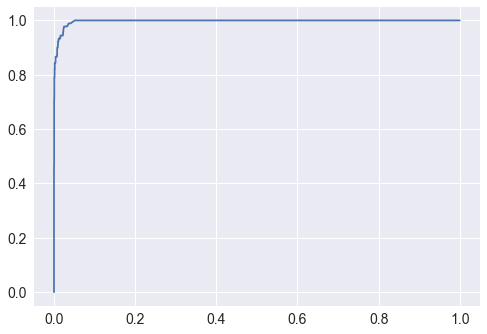

In [123]:
plotter.plot_auc(pipeline, X_test, y_test)

In [55]:
piperoni(RandomForestClassifier(random_state=64))

,Dataset,Cross-Val Mean,Cross-Val Scores,CV sd.
0,Validation,0.981281,"[0.981, 0.982, 0.981]",0.0005
1,Test (hold),0.982001,"[0.975, 0.982, 0.989]",0.0059
2,Baseline,0.966912,,


In [56]:
from imblearn.ensemble import BalancedBaggingClassifier

In [57]:
piperoni(BalancedBaggingClassifier())

,Dataset,Cross-Val Mean,Cross-Val Scores,CV sd.
0,Validation,0.957697,"[0.945, 0.966, 0.975]",0.0171
1,Test (hold),0.950792,"[0.957, 0.960, 0.949]",0.0296
2,Baseline,0.966912,,


In [58]:
model_list = [LogisticRegression(), RandomForestClassifier(), BalancedBaggingClassifier(), 
              ExtraTreeClassifier(), DecisionTreeClassifier()]

[(str(m)[0:str(m).find('(')], "{:.3f}".format(piperoni(m).loc[1, 'Cross-Val Mean'])) for m in model_list]
    

[('LogisticRegression', '0.981'),
 ('RandomForestClassifier', '0.978'),
 ('BalancedBaggingClassifier', '0.947'),
 ('ExtraTreeClassifier', '0.971'),
 ('DecisionTreeClassifier', '0.969')]

## Visualizing
- Let's plot out a comparison to see how each classifier weights each feature
- Dendrogram
...etc

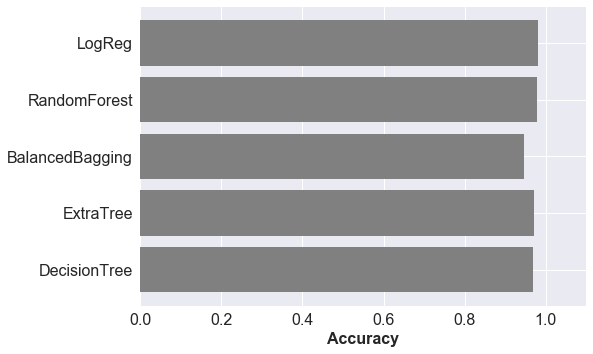

In [169]:
model_results = [('LogisticRegression', 0.981),
 ('RandomForestClassifier', 0.978),
 ('BalancedBaggingClassifier', 0.947),
 ('ExtraTreeClassifier', 0.971),
 ('DecisionTreeClassifier', 0.969)]

plt.barh(y = ['LogReg', 'RandomForest', 'BalancedBagging', 
              'ExtraTree', 'DecisionTree'][::-1], 
        width = [score[1] for score in model_results][::-1],
        color='gray');
plt.xlim(0, 1.1);
plt.xlabel('Accuracy', fontsize=16, weight='bold');
plt.tick_params(labelsize=16);

In [59]:
coefdf.head()

,logreg_coef,logreg_abs_coef,rf_coefs
age,0.143205,0.143205,0.007376
g,-1.299221,1.299221,0.006272
gs,0.076974,0.076974,0.009941
mp,-0.431992,0.431992,0.005829
per,0.025644,0.025644,0.027529


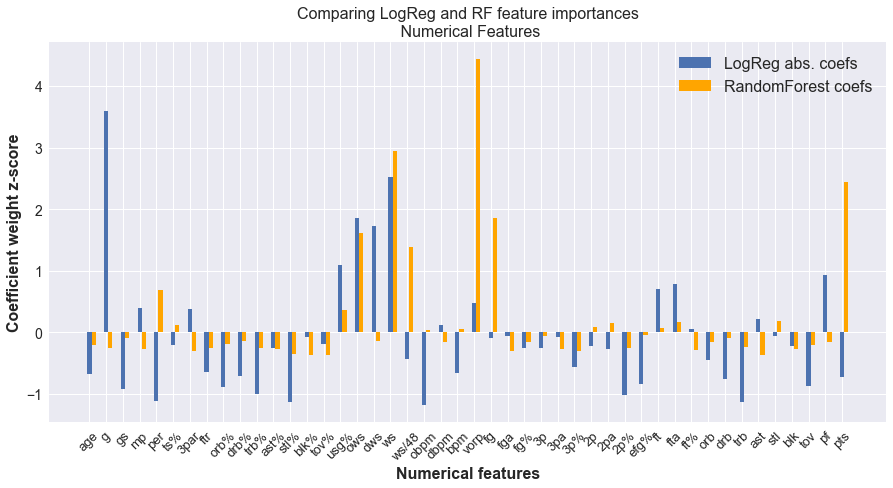

In [60]:
# can only compare LR_abs to RF b/c RF only has weight, not direction

ticklocs = np.arange(0, norm_coef.loc[num_cols].shape[0])
ticklabels = norm_coef.loc[num_cols].index

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7));

plt.bar(x = ticklocs, height=norm_coef.loc[num_cols, 'logreg_abs_coef'], label='LogReg abs. coefs', 
        width=0.25);

plt.bar(x = ticklocs+0.25, height=norm_coef.loc[num_cols, 'rf_coefs'], label='RandomForest coefs', 
        width=0.25, color='orange');


plt.xticks(ticklocs, ticklabels, rotation=45, fontsize=13);
plt.tick_params('y', labelsize=14);

plt.xlabel('Numerical features', fontsize=16, weight='bold')
plt.ylabel('Coefficient weight z-score', fontsize=16, weight='bold')

plt.legend(fontsize=16);
plt.title('Comparing LogReg and RF feature importances\n Numerical Features', fontsize=16);

**Dendrogram**

In [61]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [62]:
dt = DecisionTreeClassifier(random_state=64)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=64,
            splitter='best')

Decision Tree


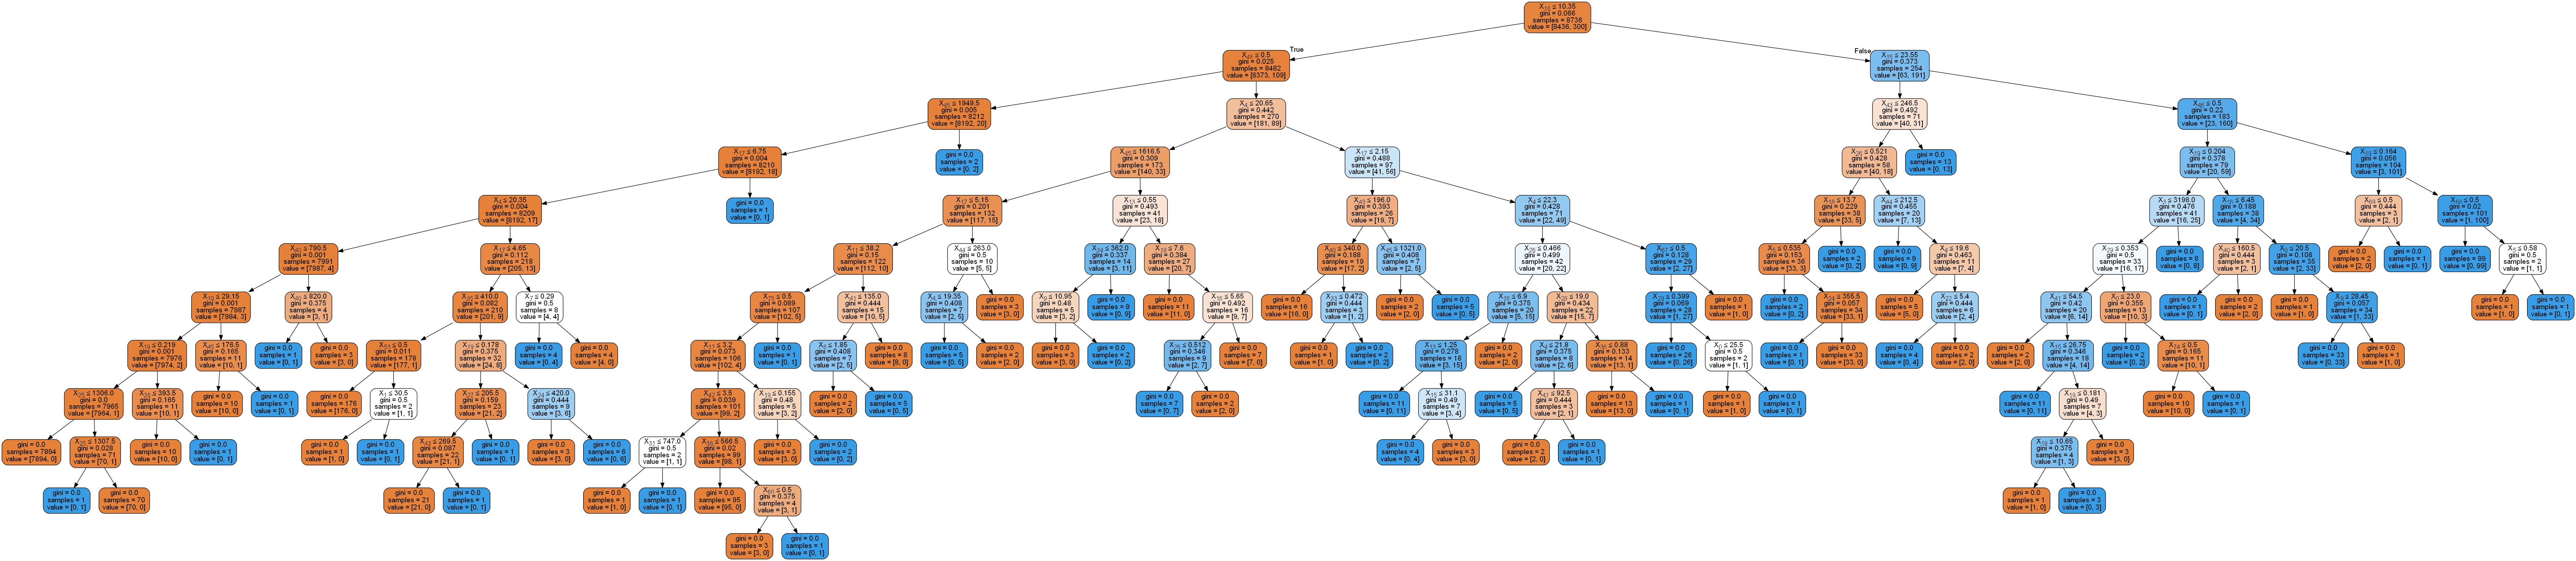

In [63]:
dot_data = StringIO()  

export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
print('Decision Tree')
Image(graph.create_png())  

**Confusion Matrix**

In [64]:
from sklearn.metrics import confusion_matrix

In [65]:
pipeline.named_steps['model']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=64, verbose=0, warm_start=False)

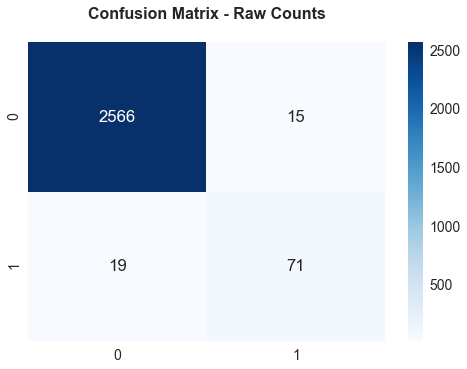

In [66]:
# raw num
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix(y_test, pipeline.predict(X_test)), cmap='Blues', annot=True, fmt='d');
plt.title('Confusion Matrix - Raw Counts\n', fontsize=16, weight='bold');

Total Accuracy: 98.13%


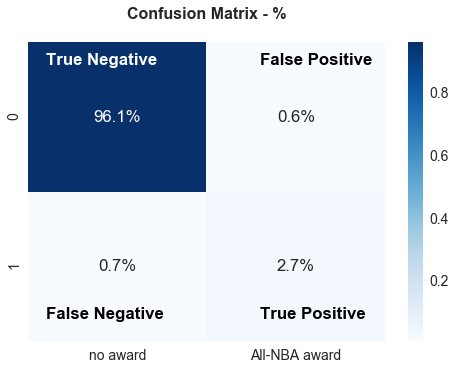

In [67]:
# raw num
sns.set(font_scale=1.4)

conf = confusion_matrix(y_test, pipeline.predict(X_test))/X_test.shape[0]

sns.heatmap(conf, cmap='Blues', annot=True, 
           xticklabels=['no award', 'All-NBA award'], fmt='.1%');

#label conf. matrix
plt.text(x = .1, y = 1.85, s='True Negative', color='white', weight='bold')
plt.text(x = 1.3, y = 1.85, s='False Positive', color='black', weight='bold')
plt.text(x = .1, y = .15, s='False Negative', color='black', weight='bold')
plt.text(x = 1.3, y = .15, s='True Positive', color='black', weight='bold')

# label things
plt.tick_params(labelsize=14);
plt.title('Confusion Matrix - %\n', fontsize=16, weight='bold');

print('Total Accuracy: ' + "{:.2%}".format(cross_val_score(pipeline, X_test, y_test).mean()))

Total Accuracy: 98.50%


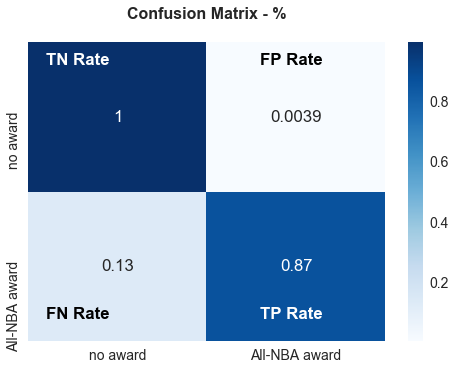

In [170]:
# raw num
sns.set(font_scale=1.4)

conf = pd.DataFrame(confusion_matrix(y_test, pipeline.predict(X_test)),
                   columns = ['predicted_no_award', 'predicted_award'])

sns.heatmap(conf.apply(lambda x: x/x.sum(), axis=1), cmap='Blues', annot=True, 
           xticklabels=['no award', 'All-NBA award'],
           yticklabels=['no award', 'All-NBA award']);

#label conf. matrix
plt.text(x = .1, y = 1.85, s='TN Rate', color='white', weight='bold')
plt.text(x = 1.3, y = 1.85, s='FP Rate', color='black', weight='bold')
plt.text(x = .1, y = .15, s='FN Rate', color='black', weight='bold')
plt.text(x = 1.3, y = .15, s='TP Rate', color='white', weight='bold')

# label things
plt.tick_params(labelsize=14);
plt.title('Confusion Matrix - %\n', fontsize=16, weight='bold');

print('Total Accuracy: ' + "{:.2%}".format(cross_val_score(pipeline, X_test, y_test).mean()))

In [171]:
print('Validation')
print(cross_val_score(pipeline, X_test, y_test))
print(cross_val_score(pipeline, X_test, y_test).mean())
print()
print('Test')
print(cross_val_score(pipeline, X_hold, y_hold))
print(cross_val_score(pipeline, X_hold, y_hold).mean())

Validation
[0.98653199 0.98651685 0.98202247]
0.9850237707915611

Test
[0.97122302 0.98201439 0.98555957]
0.9795989922863152


In [68]:
import plotter

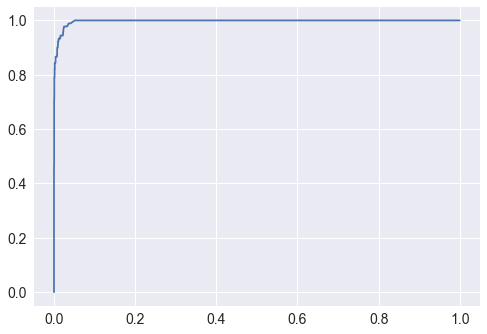

In [172]:
plotter.plot_auc(pipeline, X_test, y_test)

In [70]:
tn, fp, fn, tp = confusion_matrix(y_test, pipeline.predict(X_test)).ravel()

In [71]:
confusion_matrix(y_test, pipeline.predict(X_test)).ravel()

array([2566,   15,   19,   71], dtype=int64)

#### let's make a function

In [72]:
def plot_confusion(estimator, X, y_true):
    """Plots a labeled confusion matrix for binary classification estimators.
    Annotates with %s for TN, FP, FN, TP."""
    
    # set font to be bigger
    sns.set(font_scale=1.4)

    # set your confusion matrix
    conf = confusion_matrix(y_true, estimator.predict(X))/X.shape[0]

    sns.heatmap(conf, cmap='Blues', annot=True, fmt='.1%');

    #label conf. matrix
    plt.text(x = .1, y = 1.85, s='TN', color='gray', weight='bold')
    plt.text(x = 1.8, y = 1.85, s='FP', color='gray', weight='bold')
    plt.text(x = .1, y = .15, s='FN', color='gray', weight='bold')
    plt.text(x = 1.8, y = .15, s='TP', color='gray', weight='bold')

    # label other things
    plt.tick_params(labelsize=14);
    plt.title('Confusion Matrix - %\n', fontsize=16, weight='bold');
    
    print('Total Accuracy: ' + "{:.2%}".format(cross_val_score(estimator, X, y_true).mean()))

Total Accuracy: 98.13%


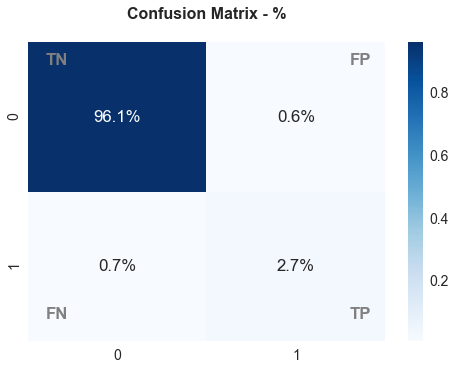

In [73]:
plot_confusion(pipeline, X_test, y_test)

### Moving on...
- Gotta pull out the actual teams

In [74]:
pd.Series(pipeline.predict_proba(X_test)[:,1])[:10]

0    0.0
1    0.0
2    0.0
3    0.1
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
dtype: float64

In [75]:
X_test.shape, y_test.shape

((2671, 83), (2671,))

In [76]:
## make a DF
pred_test_lr1 = pd.concat([model_df.loc[model_df['year'].isin(test_yrs), ['year','player', 'award_tm', 'listed_pos', 'tm_name', 'award_pos']].reset_index(drop=True),
                           X_test, y_test.reset_index(drop=True).reset_index(drop=True), 
                           pd.Series(pipeline.predict_proba(X_test)[:,1])],
                          axis=1).rename(columns={0:'proba'})

In [77]:
pred_test_lr1.head()

,year,player,award_tm,listed_pos,tm_name,award_pos,age,g,gs,mp,...,tm_encode_SAS,tm_encode_TOR,tm_encode_TOT,tm_encode_UTA,tm_encode_WAS,pos_encode_C,pos_encode_F,pos_encode_G,target,proba
0,1992.0,alaa abdelnaby,0,PF,POR,F,23.0,71.0,1.0,934.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0
1,1992.0,mahmoud abdul-rauf,0,PG,DEN,G,22.0,81.0,11.0,1538.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0
2,1992.0,mark acres,0,C,ORL,C,29.0,68.0,6.0,926.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0
3,1992.0,michael adams,0,PG,WAS,G,29.0,78.0,78.0,2795.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.1
4,1992.0,rafael addison,0,SF,BRK,F,27.0,76.0,8.0,1175.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0


In [78]:
pred_test_lr1.year.unique()

array([1992., 1996., 2001., 2005., 2013., 2017.])

In [79]:
mask = (pred_test_lr1['pos_encode_C'] == 1) & (pred_test_lr1['year'] == 1992)
interestcols = ['year','g', 'player', 'tm_name','award_tm', 'listed_pos', 'target', 'proba']

pred_test_lr1.loc[mask, interestcols].sort_values(by='proba', ascending=False).head(5)

,year,g,player,tm_name,award_tm,listed_pos,target,proba
112,1992.0,82.0,patrick ewing,NYK,2,C,1,0.9
294,1992.0,68.0,david robinson,SAS,1,C,1,0.8
84,1992.0,73.0,brad daugherty,CLE,3,C,1,0.8
251,1992.0,70.0,hakeem olajuwon,HOU,0,C,0,0.7
243,1992.0,71.0,dikembe mutombo,DEN,0,C,0,0.4


In [80]:
mask = (pred_test_lr1['pos_encode_G'] == 1) & (pred_test_lr1['year'] == 1996)

pred_test_lr1.loc[mask, interestcols].sort_values(by='proba', ascending=False).head(10)

,year,g,player,tm_name,award_tm,listed_pos,target,proba
539,1996.0,82.0,anfernee hardaway,ORL,1,PG,1,1.0
575,1996.0,82.0,michael jordan,CHI,1,SG,1,1.0
426,1996.0,75.0,terrell brandon,CLE,0,PG,0,0.8
753,1996.0,82.0,john stockton,UTA,2,PG,1,0.7
669,1996.0,81.0,gary payton,OKC,2,PG,1,0.6
634,1996.0,76.0,reggie miller,IND,3,SG,1,0.5
700,1996.0,81.0,mitch richmond,SAC,3,SG,1,0.2
485,1996.0,52.0,clyde drexler,HOU,0,SG,0,0.2
554,1996.0,82.0,jeff hornacek,UTA,0,SG,0,0.2
569,1996.0,56.0,kevin johnson,PHO,0,PG,0,0.1


In [81]:
mask = (pred_test_lr1['pos_encode_F'] == 1) & (pred_test_lr1['year'] == 1996)

pred_test_lr1.loc[mask, interestcols].sort_values(by='proba', ascending=False).head(15)

,year,g,player,tm_name,award_tm,listed_pos,target,proba
550,1996.0,80.0,grant hill,DET,2,SF,1,1.0
610,1996.0,82.0,karl malone,UTA,1,PF,1,0.9
578,1996.0,79.0,shawn kemp,OKC,2,PF,1,0.9
407,1996.0,71.0,charles barkley,PHO,3,PF,1,0.8
682,1996.0,77.0,scottie pippen,CHI,1,SF,1,0.6
698,1996.0,79.0,glen rice,CHA,0,SF,0,0.4
558,1996.0,81.0,juwan howard,WAS,3,PF,1,0.3
449,1996.0,78.0,cedric ceballos,LAL,0,SF,0,0.3
570,1996.0,81.0,larry johnson,CHA,0,PF,0,0.2
796,1996.0,80.0,jayson williams,BRK,0,PF,0,0.1


### 2017

In [82]:
## Guards
mask = (pred_test_lr1['pos_encode_G'] == 1) & (pred_test_lr1['year'] == 2017)

pred_test_lr1.loc[mask, interestcols].sort_values(by='proba', ascending=False).head(10)

,year,g,player,tm_name,award_tm,listed_pos,target,proba
2292,2017.0,74.0,demar derozan,TOR,3,SG,1,1.0
2282,2017.0,79.0,stephen curry,GSW,2,PG,1,0.9
2642,2017.0,81.0,russell westbrook,OKC,1,PG,1,0.8
2535,2017.0,61.0,chris paul,LAC,0,PG,0,0.7
2356,2017.0,81.0,james harden,HOU,1,PG,1,0.7
2636,2017.0,78.0,john wall,WAS,3,PG,1,0.7
2399,2017.0,72.0,kyrie irving,CLE,0,PG,0,0.6
2608,2017.0,76.0,isaiah thomas,BOS,2,PG,1,0.6
2611,2017.0,78.0,klay thompson,GSW,0,SG,0,0.5
2271,2017.0,69.0,mike conley,MEM,0,PG,0,0.4


In [83]:
## Forwards
mask = (pred_test_lr1['pos_encode_F'] == 1) & (pred_test_lr1['year'] == 2017)

pred_test_lr1.loc[mask, interestcols].sort_values(by='proba', ascending=False).head(10)

,year,g,player,tm_name,award_tm,listed_pos,target,proba
2445,2017.0,74.0,kawhi leonard,SAS,1,SF,1,1.0
2404,2017.0,74.0,lebron james,CLE,1,SF,1,1.0
2200,2017.0,80.0,giannis antetokounmpo,MIL,2,SF,1,1.0
2250,2017.0,76.0,jimmy butler,CHI,3,SF,1,0.9
2303,2017.0,62.0,kevin durant,GSW,2,SF,1,0.9
2369,2017.0,73.0,gordon hayward,UTA,0,SF,0,0.8
2348,2017.0,76.0,draymond green,GSW,3,PF,1,0.2
2201,2017.0,74.0,carmelo anthony,NYK,0,SF,0,0.1
2646,2017.0,82.0,andrew wiggins,MIN,0,SF,0,0.1
2334,2017.0,75.0,paul george,IND,0,SF,0,0.1


In [84]:
## Centers
maskyear = 2017
maskpos = 'C'

mask = (pred_test_lr1['pos_encode_'+maskpos] == 1) & (pred_test_lr1['year'] == maskyear)

pred_test_lr1.loc[mask, interestcols].sort_values(by='proba', ascending=False).head(6)

,year,g,player,tm_name,award_tm,listed_pos,target,proba
2284,2017.0,75.0,anthony davis,NOP,1,C,1,0.8
2424,2017.0,81.0,deandre jordan,LAC,3,C,1,0.6
2274,2017.0,72.0,demarcus cousins,TOT,0,C,0,0.6
2617,2017.0,82.0,karl-anthony towns,MIN,0,C,0,0.6
2339,2017.0,81.0,rudy gobert,UTA,2,C,1,0.5
2417,2017.0,73.0,nikola jokic,DEN,0,C,0,0.4


### Model Tune up  
**Adding some features**
- Per game features:
    - `'mp', 'fg', 'fga', '2p', '2pa', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts'`
- `'listed_pos'` label encoded and in model?
- Team stuff...

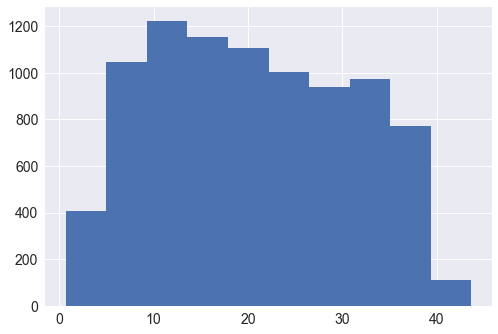

In [85]:
plt.hist(X_train['mp'] / X_train['g']);

In [86]:
## Set columns needed for per game
pergame_cols = ['mp', 'fg', 'fga', '2p', '2pa', 'ft', 'fta', 'orb', 'drb', 
                'trb','ast', 'stl', 'blk', 'tov', 'pf', 'pts']

In [87]:
for i in pergame_cols:
    colname = i + '_per_game'
    X_train[colname] = X_train[i] / X_train['g']
    X_test[colname] = X_test[i] / X_test['g']
    X_hold[colname] = X_hold[i] / X_hold['g']
    
X_train.head()

,age,g,gs,mp,per,ts%,3par,ftr,orb%,drb%,...,fta_per_game,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game
0,41.0,74.0,74.0,1695.0,12.9,0.511,0.005,0.250,7.3,14.2,...,2.229730,1.391892,3.121622,4.513514,1.000000,0.513514,1.148649,1.283784,2.648649,10.108108
1,26.0,62.0,0.0,632.0,8.2,0.507,0.009,0.421,10.9,15.6,...,0.774194,0.951613,1.403226,2.354839,0.306452,0.306452,0.096774,0.370968,1.516129,2.209677
2,26.0,77.0,77.0,2787.0,17.5,0.567,0.431,0.363,2.5,8.3,...,5.103896,0.922078,2.753247,3.675325,6.363636,2.155844,0.142857,2.337662,1.935065,18.493506
3,29.0,80.0,76.0,2597.0,16.4,0.524,0.137,0.309,6.4,10.0,...,4.912500,1.825000,3.000000,4.825000,3.475000,0.562500,0.450000,2.600000,2.862500,18.887500
4,29.0,73.0,54.0,2377.0,18.0,0.554,0.290,0.228,3.3,8.7,...,3.287671,0.972603,2.520548,3.493151,5.506849,1.273973,0.109589,1.986301,2.547945,17.547945


In [88]:
model_list = [LogisticRegression(), RandomForestClassifier(), BalancedBaggingClassifier(), 
              ExtraTreeClassifier(), DecisionTreeClassifier()]

[(str(m)[0:str(m).find('(')], "{:.3f}".format(piperoni(m).loc[1, 'Cross-Val Mean'])) for m in model_list]

[('LogisticRegression', '0.980'),
 ('RandomForestClassifier', '0.976'),
 ('BalancedBaggingClassifier', '0.933'),
 ('ExtraTreeClassifier', '0.969'),
 ('DecisionTreeClassifier', '0.962')]

In [89]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('nums', Pipeline(memory=None,
     steps=[('fe', FeatureExtractor(column=['age', 'g', 'gs', 'mp', 'per', 'ts%', '3par', 'ftr', 'orb%', 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%', 'usg%', 'ows', 'dws', 'ws', 'ws/48', 'obpm', 'dbpm'...stimators=10, n_jobs=1,
            oob_score=False, random_state=64, verbose=0, warm_start=False))])

In [90]:
# set columns to do FEs on
num_cols = list(X_train.columns[:46])
cat_cols = list(X_train.columns[46:])

# set which model I'm going to use
model = LogisticRegression(random_state=64)


## set up the feature pipelines for numerical and categorical columns
num_pipe = Pipeline([
    ('fe', FeatureExtractor(num_cols)),
    ('ss', StandardScaler())
])

cat_pipe = Pipeline([
    ('fe', FeatureExtractor(cat_cols))
])


## set up final pipeline with Feature Union
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            
            ('nums', num_pipe),
            
            ('onehots', cat_pipe)
        ])), 
    ('model', model)
])


## fit the model to the training data
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('nums', Pipeline(memory=None,
     steps=[('fe', FeatureExtractor(column=['age', 'g', 'gs', 'mp', 'per', 'ts%', '3par', 'ftr', 'orb%', 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%', 'usg%', 'ows', 'dws', 'ws', 'ws/48', 'obpm', 'dbpm'...alty='l2', random_state=64, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [91]:
print('Validation')
print(cross_val_score(pipeline, X_test, y_test))
print(cross_val_score(pipeline, X_test, y_test).mean())
print()
print('Test')
print(cross_val_score(pipeline, X_hold, y_hold))
print(cross_val_score(pipeline, X_hold, y_hold).mean())

Validation
[0.98653199 0.98651685 0.98202247]
0.9850237707915611

Test
[0.97122302 0.98201439 0.98555957]
0.9795989922863152


In [92]:
coefdf_pergame = pd.DataFrame(data=pipeline.named_steps['model'].coef_, index=['coef'], columns=X_train.columns).T

In [93]:
coefdf_pergame['abs_coef'] = coefdf_pergame['coef'].apply(lambda x: abs(x))

In [94]:
coefdf_pergame.sort_values(by='coef', ascending=False).head()

,coef,abs_coef
ws,1.455713,1.455713
all_star,1.342248,1.342248
starter,1.239715,1.239715
ows,1.108357,1.108357
mp,1.075516,1.075516


In [95]:
new_num_cols = [i for i in list(coefdf_pergame.index) if i not in cat_cols]

In [96]:
new_num_cols.extend([i + '_per_game' for i in pergame_cols])

In [97]:
coef_compare = pd.concat([coefdf_pergame.loc[new_num_cols, 'coef'], coefdf.loc[new_num_cols, 'logreg_coef'].fillna(0)], axis=1)

C:\Users\james\Anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


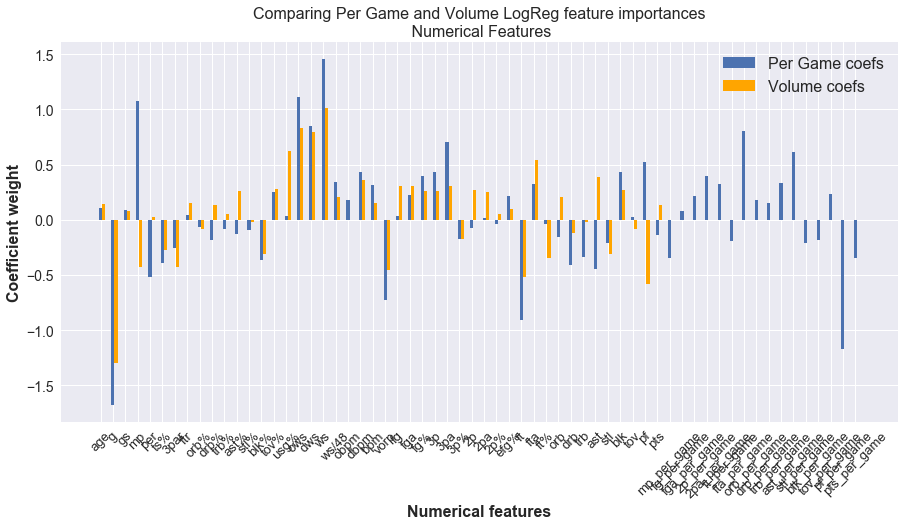

In [98]:
# can only compare LR_abs to RF b/c RF only has weight, not direction

ticklocs = np.arange(0, coef_compare.shape[0])
ticklabels = coef_compare.index

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7));

plt.bar(x = ticklocs, height=coef_compare['coef'], label='Per Game coefs', 
        width=0.25);

plt.bar(x = ticklocs+0.25, height=coef_compare['logreg_coef'], label='Volume coefs', 
        width=0.25, color='orange');


plt.xticks(ticklocs, ticklabels, rotation=45, fontsize=13);
plt.tick_params('y', labelsize=14);

plt.xlabel('Numerical features', fontsize=16, weight='bold')
plt.ylabel('Coefficient weight', fontsize=16, weight='bold')

plt.legend(fontsize=16);
plt.title('Comparing Per Game and Volume LogReg feature importances\n Numerical Features', fontsize=16);

In [99]:
def sign_function(number):
    if number < 0:
        return 1
    else:
        return 0

In [100]:
coef_compare['sign_dif'] = [sign_function(i) for i in coef_compare['coef'] * coef_compare['logreg_coef']]

In [101]:
coef_compare[(coef_compare['sign_dif'] == 1)]

,coef,logreg_coef,sign_dif
mp,1.075516,-0.431992,1
per,-0.519599,0.025644,1
drb%,-0.179690,0.132309,1
trb%,-0.080006,0.054139,1
ast%,-0.133189,0.258000,1
obpm,0.176419,-0.005724,1
2p,-0.075376,0.265559,1
2p%,-0.036632,0.051916,1
orb,-0.152137,0.204504,1
ast,-0.444264,0.386033,1


### Make a new DF

In [102]:
pred_test_lr2 = pd.concat([model_df.loc[model_df['year'].isin(test_yrs), ['year','player', 'award_tm', 'listed_pos', 'tm_name', 'award_pos']].reset_index(drop=True),
                           X_test, y_test.reset_index(drop=True).reset_index(drop=True), 
                           pd.Series(pipeline.predict_proba(X_test)[:,1])],
                          axis=1).rename(columns={0:'proba'})

In [103]:
pred_names = pd.DataFrame()

for year in pred_test_lr1['year'].unique():
    for pos in model_df.award_pos.unique():
#         print(year, 'pos_encode_'+pos)
        
        maskyear = year
        maskpos = pos

        mask = (pred_test_lr1['pos_encode_'+maskpos] == 1) & (pred_test_lr1['year'] == maskyear)
        
        
        ## control flow:
        if maskpos != 'C':
        
#             print(pred_test_lr1.loc[mask, ['year', 'player', 'proba']].sort_values(by='proba', ascending=False).head(6))
#             print()
            pred_names = pred_names.append(pred_test_lr1.loc[mask, ['year', 'player', 'award_pos','proba', 'target']].sort_values(by='proba', ascending=False).head(6))
                    
        else:
#             print(pred_test_lr1.loc[mask, ['year', 'player', 'proba']].sort_values(by='proba', ascending=False).head(3))
#             print()
            pred_names = pred_names.append(pred_test_lr1.loc[mask, ['year', 'player', 'award_pos','proba', 'target']].sort_values(by='proba', ascending=False).head(3))

        
pred_names = pred_names.reset_index(drop=True)
pred_names.head()

,year,player,award_pos,proba,target
0,1992.0,patrick ewing,C,0.9,1
1,1992.0,david robinson,C,0.8,1
2,1992.0,brad daugherty,C,0.8,1
3,1992.0,michael jordan,G,1.0,1
4,1992.0,john stockton,G,0.9,1


In [104]:
pred_award_pos = [1, 2, 3, 1, 1, 2, 2, 3, 3, 1, 1, 2, 2, 3, 3] * pred_names.year.nunique()
pred_names['pred_award_pos'] = pred_award_pos

In [105]:
## need to make a binary flag as well as a year-player column
pred_names['year-player'] = pred_names['year'].astype(str) + pred_names['player']
pred_names['predicted'] = 1

In [106]:
pred_names.head()

,year,player,award_pos,proba,target,pred_award_pos,year-player,predicted
0,1992.0,patrick ewing,C,0.9,1,1,1992.0patrick ewing,1
1,1992.0,david robinson,C,0.8,1,2,1992.0david robinson,1
2,1992.0,brad daugherty,C,0.8,1,3,1992.0brad daugherty,1
3,1992.0,michael jordan,G,1.0,1,1,1992.0michael jordan,1
4,1992.0,john stockton,G,0.9,1,1,1992.0john stockton,1


In [107]:
## saving progress
pred_names.to_csv('./data/pred_names.csv', index=False)

In [108]:
player_compare_cols = list(pred_test_lr2.columns[0:pred_test_lr2.columns.get_loc('fg')]) +  ['fg%', '3p%', '2p%', 'efg%', 'ft%'] + list(pred_test_lr2.columns[pred_test_lr2.columns.get_loc('mp_per_game'):])

In [109]:
## Need to compare this.

brad_hakeem = pred_test_lr2.loc[(pred_test_lr2.year == 1992) & (pred_test_lr2.player.isin(['brad daugherty', 'hakeem olajuwon'])),
                  player_compare_cols].T

brad_hakeem.join(coef_compare['coef']).sort_values(by='coef', ascending=False).rename(columns={84:'brad', 251: 'hakeem'})

,brad,hakeem,coef
ws,11.7,9.8,1.455713
ows,8.2,4.2,1.108357
mp,2643,2636,1.075516
dws,3.5,5.6,0.853270
fta_per_game,7.30137,6.11429,0.799627
ast_per_game,3.58904,2.24286,0.609618
dbpm,1.1,4.3,0.428611
fg%,0.57,0.502,0.399764
2p_per_game,7.89041,8.44286,0.394257
ws/48,0.213,0.178,0.337694


**Answer:** Win shares (primarily OWS), and fouls/game (neg)

## Save model to disk!

In [110]:
pipeline.named_steps['model']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=64, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [111]:
# save the model to disk
import pickle
from sklearn.externals import joblib
filename = 'logreg_ppg.pkl'
pickle.dump(pipeline, open(filename, 'wb'))
# joblib.dump(pipeline, filename)

In [112]:
print(cross_val_score(pipeline, X_hold, y_hold))
print(cross_val_score(pipeline, X_hold, y_hold).mean())

[0.97122302 0.98201439 0.98555957]
0.9795989922863152


In [113]:
## save CSVs
X_train.to_csv('./data/X_train_v2.csv', index=False)
X_test.to_csv('./data/X_test_v2.csv', index=False)
X_hold.to_csv('./data/X_hold_v2.csv', index=False)

y_train.to_csv('./data/y_train_v2.csv', index=False)
y_test.to_csv('./data/y_test_v2.csv', index=False)
y_hold.to_csv('./data/y_hold_v2.csv', index=False)

model_df.to_csv('./data/model_df.csv', index=False)

In [114]:
## Make probas for all of them
X_train['probas'] = pipeline.predict_proba(X_train)[:,1]
X_test['probas'] = pipeline.predict_proba(X_test)[:,1]
X_hold['probas'] = pipeline.predict_proba(X_hold)[:,1]

In [115]:
## make a DF
pred_train = pd.concat([model_df.loc[model_df['year'].isin(train_yrs), drop_cols].reset_index(drop=True),
                                     X_train], axis=1)

pred_test_full = pd.concat([model_df.loc[model_df['year'].isin(test_yrs), drop_cols].reset_index(drop=True),
                           X_test], axis=1)

pred_hold = pd.concat([model_df.loc[model_df['year'].isin(hold_yrs), drop_cols].reset_index(drop=True),
                           X_hold], axis=1)

In [116]:
# Make mega-DF
pred_full = pd.concat([pred_train, pred_test_full, pred_hold])

In [117]:
## save it!
pred_full.to_csv('./data/pred_full.csv', index=False)

### More Feature Importance

In [118]:
## Absolute
coef_compare['logreg_coef'].map(lambda x: abs(x)).sort_values(ascending=False).head()

g       1.299221
ws      1.011342
ows     0.829574
dws     0.793089
usg%    0.621424
Name: logreg_coef, dtype: float64

In [119]:
## Top Pos
coef_compare['logreg_coef'].sort_values(ascending=False).head(10)

ws      1.011342
ows     0.829574
dws     0.793089
usg%    0.621424
fta     0.540262
ast     0.386033
dbpm    0.359057
fga     0.309347
3pa     0.304819
fg      0.302222
Name: logreg_coef, dtype: float64

In [120]:
## Top Neg
coef_compare['logreg_coef'].sort_values(ascending=True).head(10)

g      -1.299221
pf     -0.580520
ft     -0.517227
vorp   -0.457016
mp     -0.431992
3par   -0.430383
ft%    -0.342101
stl    -0.310098
blk%   -0.306314
ts%    -0.270598
Name: logreg_coef, dtype: float64

## NEXT STEPS
1. Make giant DF of `X_train` + `X_test` + `X_hold` together (all years)
2. Make predictions and predict_probas on them
3. Save DF to reload in "Analysis and Takeaways"

## Link to [Analysis and Takeaways v1](Analysis%20and%20Takeaways.ipynb)